In [107]:
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import geopandas
import geoplot
import geoplot.crs as gcrs

import rasterio
import rioxarray

import json
import seaborn as sns

In [108]:
AEZ_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\Kenya_Agro-Ecological_Zones_Data.geojson')
AEZ_data.loc[:, 'AEZ_Code'] = AEZ_data.loc[:, 'AEZ_Code'].str.replace(' ', '', regex=True)
for code in ['Waterbody-IL5', 'Waterbody-IL6', 'Waterbody-IL7', 
             'Waterbody-IndianOcean', 'Waterbody-LH5', 
             'Waterbody-LM3', 'Waterbody-LM4', 'Waterbody-LM5',
             'Waterbody-LM6', 'Waterbody-LakeVictoria', 'Waterbody-UM5',
             'Waterbody-UM6']: #'TA1-2', 'TA0', 'TA1', 'TA2', 'NBO'
    AEZ_data = AEZ_data.loc[AEZ_data['AEZ_Code'] != code]

In [109]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
adm_data = adm_data.explode()#.crs
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data = adm_data.drop_duplicates(subset = ['admin_1'])
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']

Skipping field centroid: unsupported OGR type: 3


In [7]:
#fig, axs = plt.subplots(1, 2)
#norm = mpl.colors.Normalize(vmin=0.,vmax=3.5)
#geoplot.choropleth(yield_data_mean.dropna(), hue='value', cmap='Oranges', ax=axs[0], legend=True, norm=norm, legend_kwargs={'fraction': 0.05})

In [110]:
calendar = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\Crop_Calendar_Data.csv').drop(0)
def timedelta_from_month_day(months, days):
    return pd.to_datetime('2000-' + months.astype(str) + '-' + days.astype(str), format='%Y-%m-%d') - pd.to_datetime('2000-01-01', format='%Y-%m-%d')

calendar.loc[:, 'Early sowing date'] = timedelta_from_month_day(calendar['Unnamed: 5'], calendar['Early Sowing'])
calendar.loc[:, 'Late sowing date'] = timedelta_from_month_day(calendar['Unnamed: 7'], calendar['Later Sowing'])
calendar.loc[:, 'Early harvest date'] = timedelta_from_month_day(calendar['Unnamed: 14'], calendar['Early harvest'])
calendar.loc[:, 'Late harvest date'] = timedelta_from_month_day(calendar['Unnamed: 16'], calendar['Late harvest'])

first_season = calendar.loc[calendar['Additional information'].str.contains('First season', case=False)]
second_season = calendar.loc[calendar['Additional information'].str.contains('Second season', case=False) | calendar['Additional information'].str.contains('Secind season', case=False)]

seasons_stacked = first_season.merge(second_season[['AgroEcological Zone', 'Early sowing date', 'Late sowing date', 'Early harvest date', 'Late harvest date']],
                                     how='outer', suffixes=(' first', ' second'), on=['AgroEcological Zone'])
#seasons_stacked = seasons_stacked.loc[seasons_stacked['AgroEcological Zone Practices'].str.contains('maize', case=False)]

In [111]:
missed = 0
total = 0
for i, adm1 in enumerate(adm_data['admin_1'].unique()[:-1]):
    total += 1
    if ~np.any(seasons_stacked.loc[:, 'AgroEcological Zone Units'].str.contains(adm1).values):
        print(adm1)
        #print(i)
        missed += 1
        adm_data.loc[adm_data['admin_1'] == adm1, 'missed'] = True
    else: 
        adm_data.loc[adm_data['admin_1'] == adm1, 'missed'] = False
        #print(seasons_stacked.loc[seasons_stacked.loc[:, 'AgroEcological Zone Units'].str.contains(adm1), ['Early sowing date first', 'Late sowing date first', 'Early harvest date first', 'Late harvest date first', 'Early sowing date second', 'Late sowing date second', 'Early harvest date second', 'Late harvest date second']].drop_duplicates())
print(f'Missed {missed} out of {total} admin 1 regions')

Mombasa
Garissa
Wajir
Mandera
Marsabit
Isiolo
Tharaka Nithi
Makueni
Murang'a
Turkana
West Pokot
Trans Nzoia
Elgeyo-Marakwet
Bomet
Vihiga
Homa Bay
Migori
Nyamira
Missed 18 out of 46 admin 1 regions


In [6]:
#seasons_stacked[seasons_stacked.loc[:, 'AgroEcological Zone Units'].str.contains('Tana river', case=False).values]

In [112]:
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'CL2(-3)', 'AEZ_Code'] = 'CL2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'CL3-4', 'AEZ_Code'] = 'CL3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LM4-5', 'AEZ_Code'] = 'LM4'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UH1-2', 'AEZ_Code'] = 'UH1'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UH2-3', 'AEZ_Code'] = 'UH2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM1-2', 'AEZ_Code'] = 'UM1'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM2-3', 'AEZ_Code'] = 'CL3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM2-4', 'AEZ_Code'] = 'UM3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM3-4', 'AEZ_Code'] = 'UM3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM4-5', 'AEZ_Code'] = 'UM4'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM5-6', 'AEZ_Code'] = 'UM5'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LH3-4', 'AEZ_Code'] = 'LH3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UH-LH3', 'AEZ_Code'] = 'LH3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LH2-3', 'AEZ_Code'] = 'LH2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LH4-5', 'AEZ_Code'] = 'LH4'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LM5-6', 'AEZ_Code'] = 'LM5'
#SAY TROPICAL ALPINE IS HIGHLAND
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA1-2', 'AEZ_Code'] = 'UH2' 
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA0', 'AEZ_Code'] = 'UH2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA1', 'AEZ_Code'] = 'UH2' #SAY TROPICAL ALPINE IS HIGHLAND
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA2', 'AEZ_Code'] = 'UH2'
#SAY Nairobi is lower highland
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'NBO', 'AEZ_Code'] = 'LH2'
for code in range(8):
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'CL{code}', 'AEZ_Code'] = f'L{code}'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'IL{code}', 'AEZ_Code'] = f'L{code}'

for code in range(5, 8):
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'L{code}', 'AEZ_Code'] = 'L4'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'UM{code}', 'AEZ_Code'] = 'UM4'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'LH{code}', 'AEZ_Code'] = 'LH4'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'LM{code}', 'AEZ_Code'] = 'LM4'
for code in range(3, 5):
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'UH{code}', 'AEZ_Code'] = 'UH2'
for code in ['LH', 'UH', 'UM']:
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'{code}0', 'AEZ_Code'] = f'{code}1'

In [113]:
AEZ_data['AEZ_Code'].unique()[~np.isin(AEZ_data['AEZ_Code'].unique(), seasons_stacked['AEZ_Code'].unique())]

array([], dtype=object)

In [114]:
AEZ_data.loc[11102:11105, 'geometry'] = AEZ_data.loc[11102:11105, 'geometry'].buffer(0)
AEZ_bounds = AEZ_data.loc[:, ['AEZ_Code', 'geometry']].dissolve(by='AEZ_Code')
AEZ_with_date = AEZ_bounds.reset_index().merge(seasons_stacked, how='left', on='AEZ_Code')#.explode()#.dropna(subset='Crop')
delta_cols =  ['Early sowing date first', 'Late sowing date first',
               'Early harvest date first', 'Late harvest date first',
               'Early sowing date second', 'Late sowing date second',
               'Early harvest date second', 'Late harvest date second']
for col in delta_cols:
    AEZ_with_date.loc[:, col] = AEZ_with_date.loc[:, col].dt.days

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25268\2193455069.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 90 105  74  59  60  74  74  74  74  60  60  74  90  45  74  60  60]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  AEZ_with_date.loc[:, col] = AEZ_with_date.loc[:, col].dt.days
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25268\2193455069.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[105 120 105  90  90  91  91 105 105  91  91  91  91  90 105  91 105]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  AEZ_with_date.loc[:, col] = AEZ_with_date.loc[:, col].dt.days
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25268\2193455069.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a fut

In [115]:
no_dates = AEZ_with_date.loc[pd.isna(AEZ_with_date['Crop'])]
no_dates['AEZ_Code'].unique()
#no_dates = no_dates.loc[(no_dates['AEZ_Code'] == 'L5') | (no_dates['AEZ_Code'] == 'L6') | (no_dates['AEZ_Code'] == 'L7')]

array([], dtype=object)

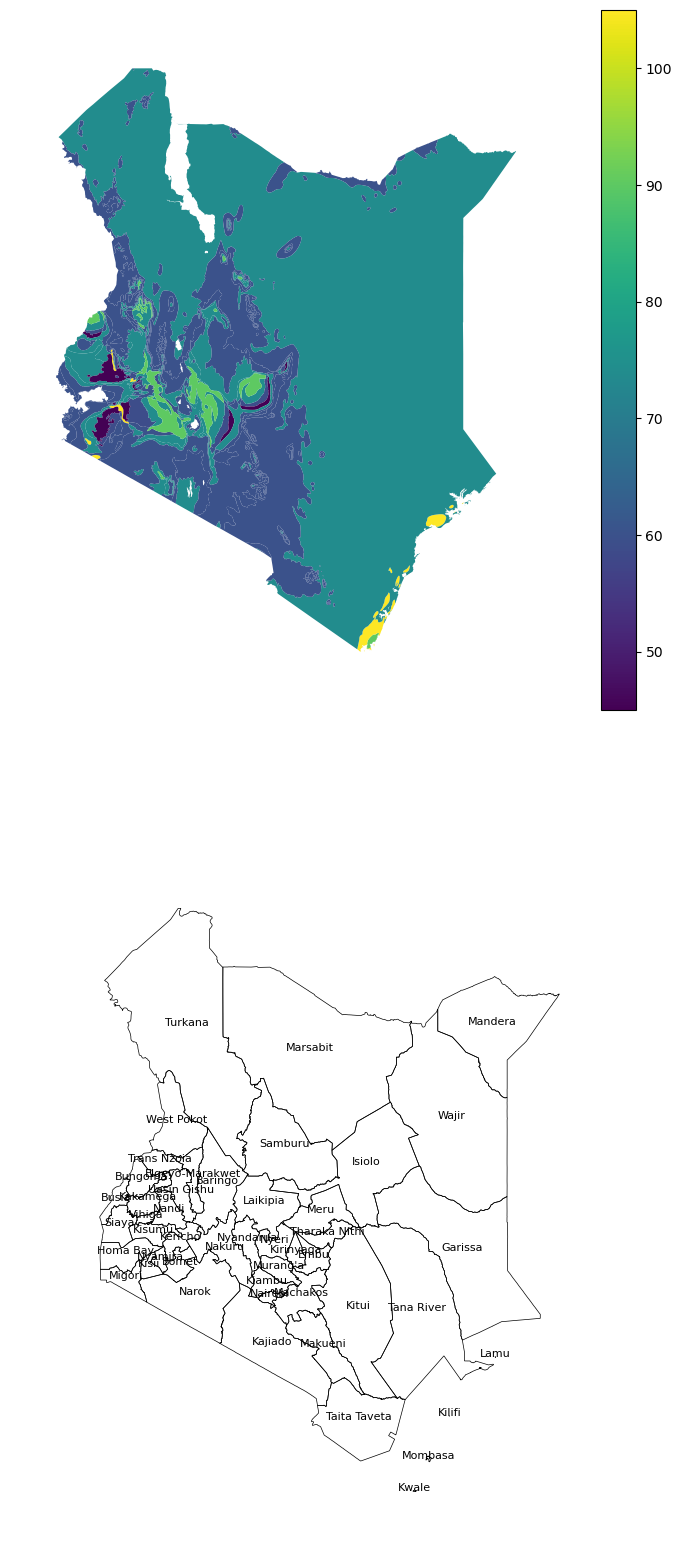

In [118]:
fig, axs = plt.subplots(2,1, figsize = (10, 20))
ax=axs[0]
#geoplot.polyplot(no_dates, linewidth = 0.5, facecolor = 'red', ax=ax)
#geoplot.polyplot(adm_data.loc[adm_data['missed'] == False], facecolor='black', ax=ax)
geoplot.choropleth(AEZ_with_date.dropna(subset=['Crop']).explode(), 
                   hue='Early sowing date first', cmap='viridis', 
                   legend=True, ax=ax, linewidth = 0.0001)
ax=axs[1]
geoplot.polyplot(adm_data.explode(), edgecolor = 'black', linewidth = 0.5, ax = ax)
for index, row in adm_data.iterrows():
    #print(row)
    #print(row['centroid'])
    plt.text(row['centroid'].x, row['centroid'].y, row['admin_1'], fontsize=8, ha='center')

In [94]:
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024.nc')
ds = clean(ds)
ds.rename({'lat': 'y', 'lon': 'x'}).rio.write_coordinate_system(inplace=True).rename({'x': 'lon', 'y': 'lat'})
#ds.to_netcdf("C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024_for_rio.nc")

<xarray.Dataset> Size: 3GB
Dimensions:                            (time: 9107, lon: 150, lat: 101, bnds: 2)
Coordinates:
  * lon                                (lon) float64 1kB 30.05 30.15 ... 44.95
  * lat                                (lat) float64 808B 4.993 4.893 ... -5.007
  * time                               (time) datetime64[ns] 73kB 2000-01-01 ...
Dimensions without coordinates: bnds
Data variables:
    temperature_2m                     (time, lon, lat) float32 552MB ...
    t2max                              (time, lon, lat) float32 552MB ...
    t2min                              (time, lon, lat) float32 552MB ...
    vpd                                (time, lon, lat) float32 552MB ...
    surface_solar_radiation_downwards  (time, lon, lat) float32 552MB ...
    total_precipitation                (time, lon, lat) float32 552MB ...
    lat_bnds                           (bnds) float64 16B -5.507 5.493
    lon_bnds                           (bnds) float64 16B 29.55 45.45
Attributes:
    date_range:  [ 347155200000 1640649600000]
    period:      0
    crs:         EPSG:4326

In [95]:

ds.to_netcdf("C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024_forrio6.nc")

In [80]:
ds.close()

In [93]:
def clean(ds):
    for v in ds.data_vars:
        #ds[v].encoding = {}       # drop encodings
        ds[v].attrs = {'id': 'temperature_2m',# 'data_type': "{'type': 'PixelType', 'precision': 'double'}", 
                       'dimensions': np.array([3601, 1801]), 'crs': 'EPSG:4326', 
                       'crs_transform': np.array([ 0.1,  0, -180.05,  0, -1,  90.05])}
    lat = ds['lat']
    lon = ds['lon']
    lat_bnds = np.array([lat.min() - 0.5, lat.max() + 0.5])
    lon_bnds = np.array([lon.min() - 0.5, lon.max() + 0.5])

    ds["lat_bnds"] = (("bnds",), lat_bnds)
    ds["lon_bnds"] = (("bnds",), lon_bnds)

    ds["lat"].attrs["bounds"] = "lat_bnds"
    ds["lon"].attrs["bounds"] = "lon_bnds"

    ds.attrs = {'date_range': np.array([ 347155200000, 1640649600000]), 
                'period': np.int64(0), 'crs': 'EPSG:4326'}
    return ds



In [104]:
xds['x'].max()

<xarray.DataArray 'x' ()> Size: 8B
array(44.95)
Coordinates:
    spatial_ref  int64 8B 0

In [98]:
#xds = rioxarray.open_rasterio('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024_forrio6.nc')
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024_forrio6.nc')
xds = ds.rio.write_crs('EPSG:4326')
#xds = xds.rio.clip_box(minx=33.5, miny=-5.5, maxx=42, maxy=5.5)

In [100]:
xds = xds.rename({'lat': 'y', 'lon': 'x'})

In [28]:
AEZ_with_date.columns

Index(['AEZ_Code', 'geometry', 'Crop', 'AgroEcological Zone',
       'Additional information', 'Early Sowing', 'Unnamed: 5', 'Later Sowing',
       'Unnamed: 7', 'All year', 'Sowing rate', 'Unnamed: 10',
       'Growing period', 'Unnamed: 12', 'Early harvest', 'Unnamed: 14',
       'Late harvest', 'Unnamed: 16', 'AgroEcological Zone Description',
       'AgroEcological Zone Practices', 'AgroEcological Zone Units',
       'Comments En', 'Comments ES', 'Comments FR', 'Comments ZH',
       'Comments AR', 'Comments RU', 'Early sowing date first',
       'Late sowing date first', 'Early harvest date first',
       'Late harvest date first', 'Early sowing date second',
       'Late sowing date second', 'Early harvest date second',
       'Late harvest date second'],
      dtype='object')

In [101]:
xds['start_date_early_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['start_date_late_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['harvest_date_early_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['harvest_date_late_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['start_date2_early_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['start_date2_late_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['harvest_date2_early_finished'] = (('x', 'y'), np.zeros((xds.sizes['x'], xds.sizes['y'])))
xds['harvest_date2_late_finished'] = (('x', 'y'),   (np.zeros((xds.sizes['x'], xds.sizes['y']))))
for index, row in AEZ_with_date.iterrows():
    print(index)
    xds['start_date_early'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Early sowing date first'])
    xds['start_date'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Late sowing date first'])
    xds['harvest_date_early'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Early harvest date first'])
    xds['harvest_date'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Late harvest date first'])
    xds['start_date2_early'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Early sowing date second'])
    xds['start_date2'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Late sowing date second'])
    xds['harvest_date2_early'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Early harvest date second'])
    xds['harvest_date2'] = (('x', 'y'), np.ones((xds.sizes['x'], xds.sizes['y']))*row['Late harvest date second'])
    clipped = xds.isel(time=0).rio.clip([row['geometry']], AEZ_with_date.crs, all_touched = False, drop=False)
    print('clipped')
    xds['start_date_early_finished'] += clipped['start_date_early'].fillna(0)
    xds['start_date_late_finished'] += clipped['start_date'].fillna(0)
    xds['harvest_date_early_finished'] += clipped['harvest_date_early'].fillna(0)
    xds['harvest_date_late_finished'] += clipped['harvest_date'].fillna(0)
    xds['start_date2_early_finished'] += clipped['start_date2_early'].fillna(0)
    xds['start_date2_late_finished'] += clipped['start_date2'].fillna(0)
    xds['harvest_date2_early_finished'] += clipped['harvest_date2_early'].fillna(0)
    xds['harvest_date2_late_finished'] += clipped['harvest_date2'].fillna(0)
    #xds.loc[clipped[['x', 'y']]]

0
clipped
1
clipped
2
clipped
3
clipped
4
clipped
5
clipped
6
clipped
7
clipped
8
clipped
9
clipped
10
clipped
11
clipped
12
clipped
13
clipped
14
clipped
15
clipped
16
clipped


In [129]:
for column in ['start_date_early_finished', 'start_date_late_finished', 
               'harvest_date_early_finished', 'harvest_date_late_finished', 
               'start_date2_early_finished', 'start_date2_late_finished', 
               'harvest_date2_early_finished', 'harvest_date2_late_finished']:
    xds[column] =xds[column].where(xds[column] > 0)
    xds[column] = xds[column].interpolate_na(dim='x')

In [132]:
xds.to_netcdf('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024_with_dates2.nc')

In [105]:
xds['y'].max()

<xarray.DataArray 'y' ()> Size: 8B
array(4.99292327)
Coordinates:
    spatial_ref  int64 8B 0

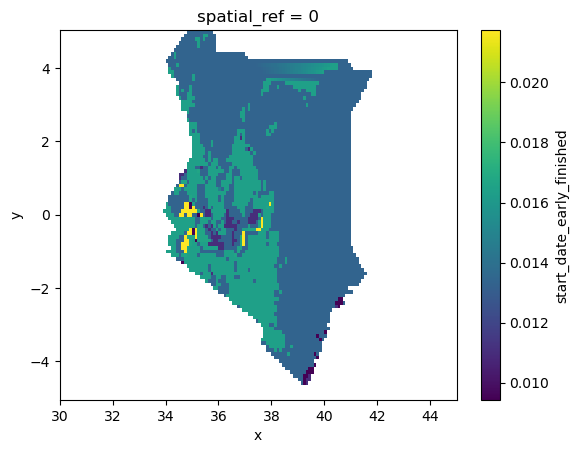

In [131]:
(1/(xds['start_date_early_finished'] + 1)).T.plot()

In [124]:
xds.where(xds['start_date_early_finished'] == 0)['start_date_early_finished'] = 100

In [119]:
np.ones((xds.sizes['x'], xds.sizes['y']))

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(71, 111))

In [106]:
AEZ_with_date['geometry'].area#.max()

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_13464\3558894608.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  AEZ_with_date['geometry'].area#.max()


0      0.024321
1      0.272757
2     31.230682
3      0.437293
4      0.410089
5      0.732664
6      0.784301
7      0.311564
8      0.342230
9      0.531172
10     6.262630
11     0.499926
12     0.733463
13     0.410234
14     0.256915
15     0.529920
16     3.265105
dtype: float64

In [85]:
xds_clipped = xds.where(clipped)#.t2m.plot()

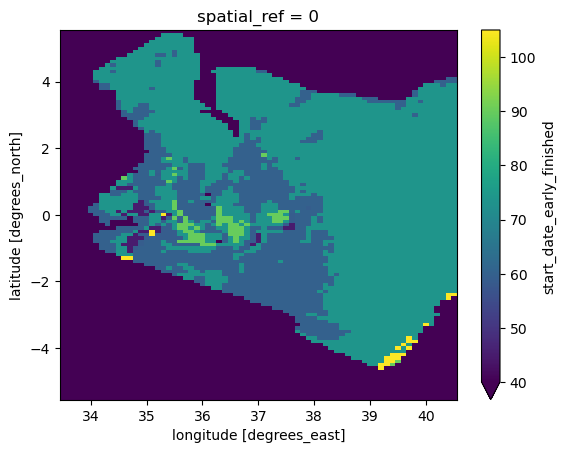

In [133]:
xds['start_date'] = clipped.start_date
xds['start_date_early_finished'].T.plot(vmin=40)

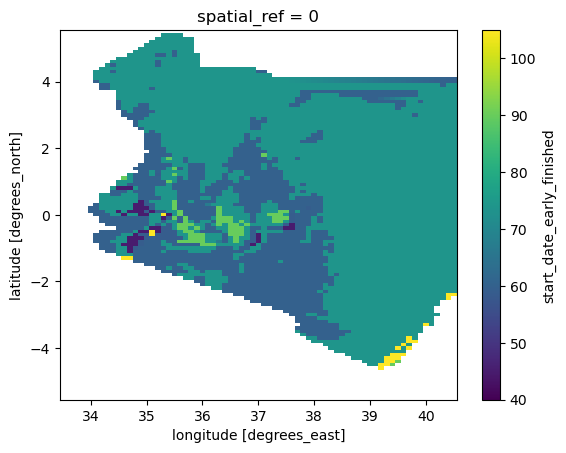

In [138]:
xds['start_date_early_finished'].where(xds['start_date_early_finished'] > 0).interpolate_na(dim='x').T.plot(vmin=40)

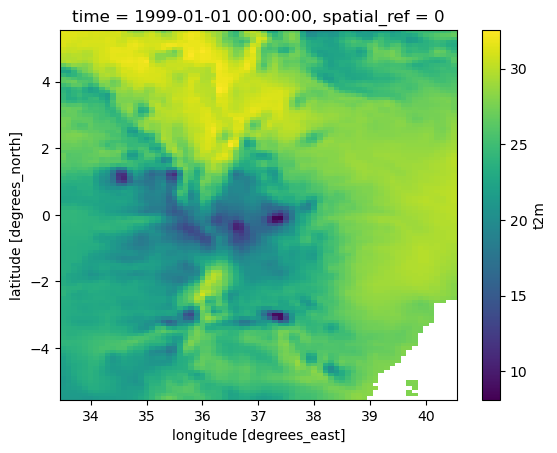

In [ ]:
xds.loc[clipped[['x', 'y']]].isel(time=0).t2m.plot()

In [69]:
clipped.x.max()

<xarray.DataArray 'x' ()> Size: 8B
array(40.5)
Coordinates:
    time         object 8B 1999-01-01 00:00:00
    spatial_ref  int64 8B 0

In [41]:
xds.isel(time=0)#.loc[clipped[['x', 'y']]].t2m.plot()

<xarray.Dataset> Size: 2MB
Dimensions:      (x: 291, y: 431)
Coordinates:
  * x            (x) float64 2kB 11.5 11.6 11.7 11.8 ... 40.2 40.3 40.4 40.5
  * y            (y) float64 3kB 12.5 12.4 12.3 12.2 ... -30.2 -30.3 -30.4 -30.5
    time         object 8B 1999-01-01 00:00:00
    spatial_ref  int64 8B 0
Data variables:
    t2m          (y, x) float32 502kB ...
    t2max        (y, x) float32 502kB ...
    t2min        (y, x) float32 502kB ...
Attributes: (12/32)
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_gridType:                            regular_ll
    GRIB_iDirectionIncrementInDegrees:        0.1
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

In [94]:
adm1 = ['Isiolo', 'Turkana', 'Marsabit', 'Wajir', 'Mandera', 'Garissa'][0]#, 'Kilifi', 'Mombasa', 'Kwale', 'Lamu']
AEZ_data[AEZ_data['County'].str.contains(adm1, case=False)]['AEZ_Code'].unique()

array(['L6', 'L7', 'LM5', 'LM6', 'UM5', 'UM6'], dtype=object)

In [28]:
#hit = adm_data.loc[adm_data['missed'] == False]
#geoplot.polyplot

In [29]:
#geoplot.choropleth(AEZ_with_date.dropna(subset=['Crop']), hue='Early sowing date first', cmap='viridis', legend=True, figsize=(10, 8))

In [92]:
#AEZ_data.loc[AEZ_data['AEZ_Code'] == 'CL3']#.columns

In [93]:
#AEZ_bounds.index.values#['AEZ_Code'].values#.explode()

In [82]:
#geoplot.polyplot(AEZ_bounds.explode(), edgecolor = 'black', linewidth = 0.5)


In [82]:
np.any(calendar.loc[:, 'AgroEcological Zone Units'].str.contains(adm_data['admin_1'].values[5]).values)

np.True_

In [12]:
#adm_data['admin_1']

In [ ]:
pd.to_datetime(calendar['Early Sowing Date'].astype(str) + '-' + df['Early Sowing Date'].astype(str), format='%m-%d')


In [14]:
#calendar.loc[:, 'Early Sowing Date'] = pd.to_timedelta(calendar['Early Sowing'].astype(int), 'D') + pd.to_timedelta(calendar['Unnamed: 4'].astype(int), 'M')